# Wild Blueberries & Bees 
Predicting blueberry yield using regression modeling
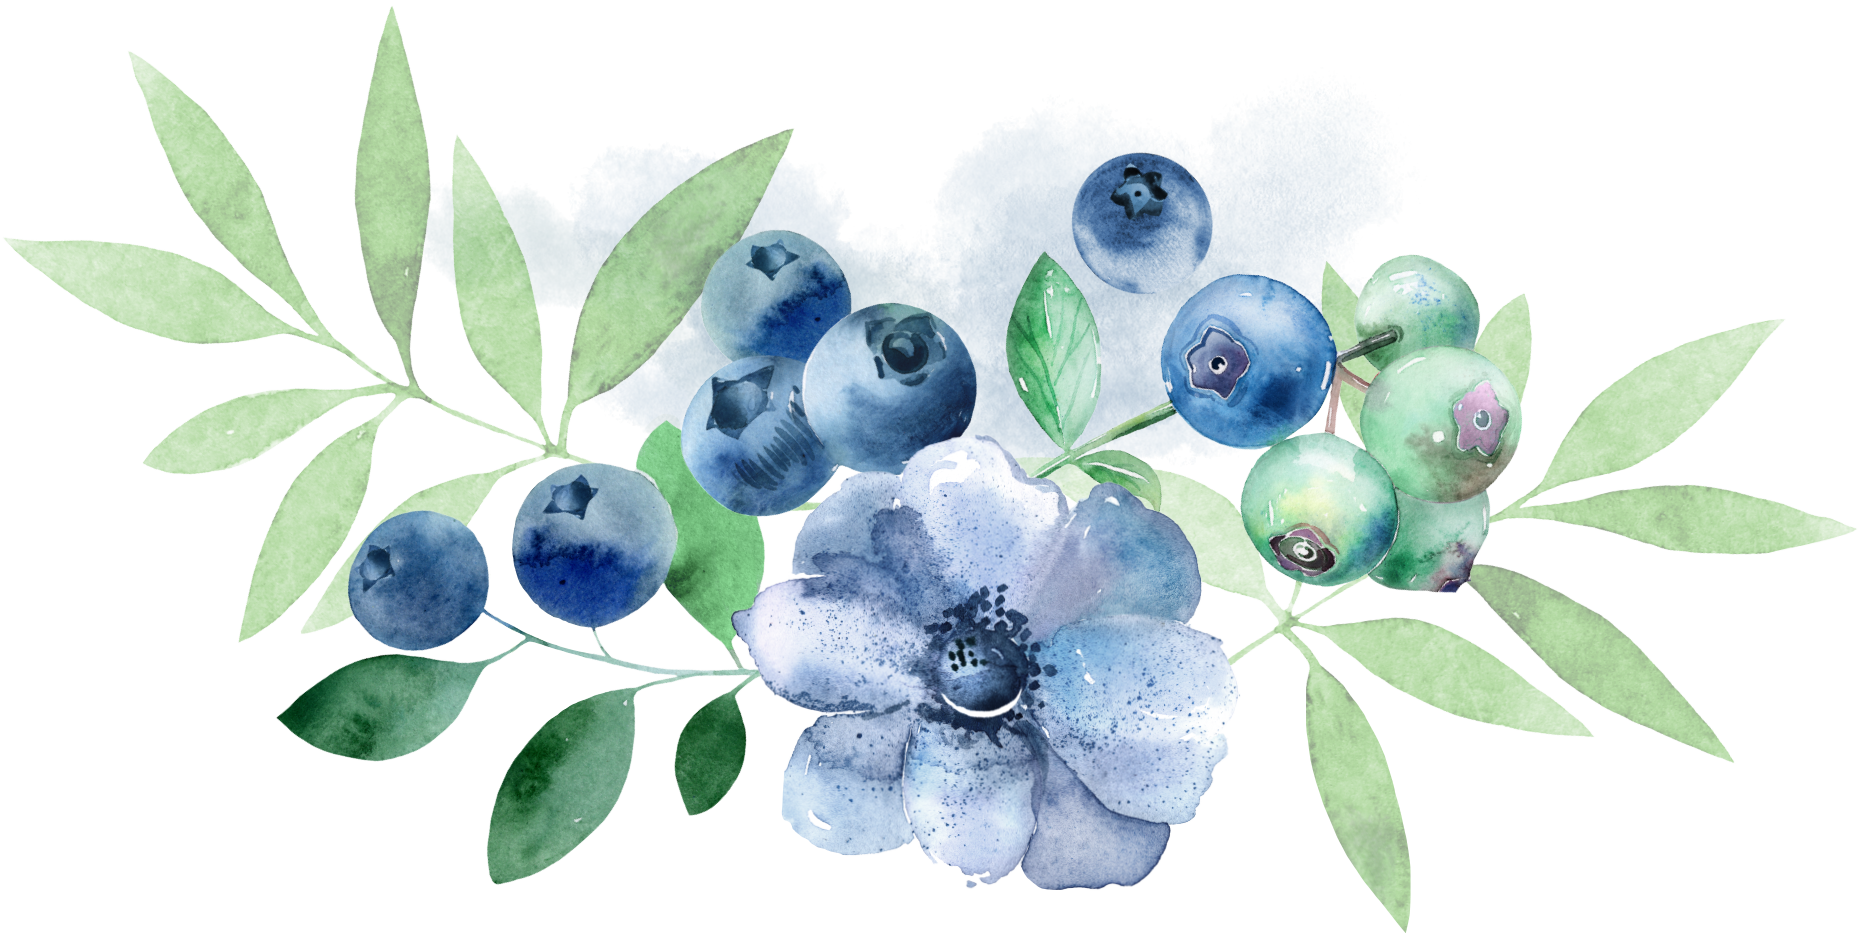


<p><h3><b>Hypothesis</b></h3></p>
<p>Bees per meter squared are more significant to yield than bee species.</p>

<p><h3><b>Tasks</b></h3></p>
<p>1. Accept or reject Hypothesis</p>
<p>2. Produce Figures to help visualize statistical relationships.</p>
<p>3. Predict Pollinator Density per fruitset record</p>
<p>4. Make recommendations to improve blueberry yields


# importing libraries 
including bigquery creds

In [1]:
import time
from google.cloud import bigquery
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV #optimixing hyperparameters of the model
from sklearn.preprocessing import StandardScaler #for pre-processing

from sklearn.ensemble import RandomForestRegressor

#import data
from sklearn.datasets import make_blobs

# scikitplot to directly plot our results
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

# matplotlib for plotting modification
import matplotlib.pyplot as plt
%matplotlib inline
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/sareenah/Desktop/blueberries/blueberries-key.json'



In [2]:
import time
from google.cloud import bigquery

query = "select * from `blueberries-and-bees.WildBlueberryPollinationSimulationData.full_data`"

client = bigquery.Client()
query_job = client.query(query)

time.sleep(2) #give the query some time to finish
result = query_job.result()


# Cleaning Data

In [3]:
#taking a look at the dataframe
data = result.to_dataframe()
data.head(10)

,Row_,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,11,37.5,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.398977,0.409269,31.597416,3941.255122
2,25,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091,4503.161856
3,40,25.0,0.25,0.25,0.25,0.38,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.443420,0.426240,33.441606,4870.625368
4,51,12.5,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.521950,0.456937,36.852363,5996.078548
5,67,12.5,0.25,0.25,0.25,0.38,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.552129,0.471650,38.577167,6578.235221
6,83,12.5,0.25,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.575590,0.482875,39.831926,6986.809961
7,99,12.5,0.25,0.25,0.25,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.595273,0.494398,41.255786,7451.725625
8,115,12.5,0.25,0.25,0.25,0.75,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.611726,0.506024,42.686614,7924.516776
9,131,12.5,0.25,0.25,0.38,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.526615,0.458255,37.031744,6026.063649


In [4]:
#confirm there are no null values (there aren't)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row_                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [5]:
#drop unnecessary row column
df = data.drop('Row_', axis = 1)

#confirm row was dropped
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             777 non-null    float64
 1   honeybee              777 non-null    float64
 2   bumbles               777 non-null    float64
 3   andrena               777 non-null    float64
 4   osmia                 777 non-null    float64
 5   MaxOfUpperTRange      777 non-null    float64
 6   MinOfUpperTRange      777 non-null    float64
 7   AverageOfUpperTRange  777 non-null    float64
 8   MaxOfLowerTRange      777 non-null    float64
 9   MinOfLowerTRange      777 non-null    float64
 10  AverageOfLowerTRange  777 non-null    float64
 11  RainingDays           777 non-null    float64
 12  AverageRainingDays    777 non-null    float64
 13  fruitset              777 non-null    float64
 14  fruitmass             777 non-null    float64
 15  seeds                 7

# Statistical Analysis

In [6]:
df.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


# Central Tendencies

In [7]:
import statistics as st

## Yield

In [8]:
print(f"Mean of yield: {st.mean(df['yield'])}\nMedian of yield: {st.median(df['yield'])}\nMode of yield: {st.mode(df['yield'])}")
print(f"Standard Deviation of yield: {st.stdev(df['yield'])}")

Mean of yield: 6012.849164670528
Median of yield: 6107.382466
Mode of yield: 3813.165795
Standard Deviation of yield: 1356.9553182555178


## Fruitmass

In [9]:
print(f"Mean of fruitmass: {st.mean(df['fruitmass'])}\nMedian of fruitmass: {st.median(df['fruitmass'])}\nMode of fruitmass: {st.mode(df['fruitmass'])}")
print(f"Standard Deviation of fruitmass: {st.stdev(df['fruitmass'])}")

Mean of fruitmass: 0.44598335463577865
Median of fruitmass: 0.445587455
Mode of fruitmass: 0.408159008
Standard Deviation of fruitmass: 0.04033266901426201


## Clonesize

In [10]:
print(f"Mean of clonesize: {st.mean(df['clonesize'])}\nMedian of clonesize: {st.median(df['clonesize'])}\nMode of clonesize: {st.mode(df['clonesize'])}")
print(f"Standard Deviation of clonesize: {st.stdev(df['clonesize'])}")

Mean of clonesize: 18.767696267696266
Median of clonesize: 12.5
Mode of clonesize: 12.5
Standard Deviation of clonesize: 6.9990628216822435


## RainingDays

In [11]:
print(f"Mean of RainingDays: {st.mean(df['RainingDays'])}\nMedian of RainingDays: {st.median(df['RainingDays'])}\nMode of RainingDays: {st.mode(df['RainingDays'])}")
print(f"Standard Deviation of RainingDays: {st.stdev(df['RainingDays'])}")

Mean of RainingDays: 18.309292149292148
Median of RainingDays: 16.0
Mode of RainingDays: 16.0
Standard Deviation of RainingDays: 12.12422583938815


## Pollinator Bee Species 
number of bees within m2 area

In [12]:
print(f"Mean of honeybee: {st.mean(df['honeybee'])}\nMedian of honeybee: {st.median(df['honeybee'])}\nMode of honeybee: {st.mode(df['honeybee'])}")
print(f"Standard Deviation of honeybee: {st.stdev(df['honeybee'])}")

Mean of honeybee: 0.41713256113256114
Median of honeybee: 0.25
Mode of honeybee: 0.25
Standard Deviation of honeybee: 0.9789037929007205


In [13]:
print(f"Mean of bumbles: {st.mean(df['bumbles'])}\nMedian of bumbles: {st.median(df['bumbles'])}\nMode of bumbles: {st.mode(df['bumbles'])}")
print(f"Standard Deviation of bumbles: {st.stdev(df['bumbles'])}")

Mean of bumbles: 0.2823886743886744
Median of bumbles: 0.25
Mode of bumbles: 0.25
Standard Deviation of bumbles: 0.0663434190632992


In [14]:
print(f"Mean of andrena: {st.mean(df['andrena'])}\nMedian of andrena: {st.median(df['andrena'])}\nMode of andrena: {st.mode(df['andrena'])}")
print(f"Standard Deviation of andrena: {st.stdev(df['andrena'])}")

Mean of andrena: 0.4688172458172458
Median of andrena: 0.5
Mode of andrena: 0.38
Standard Deviation of andrena: 0.16105207444047392


In [15]:
print(f"Mean of osmia: {st.mean(df['osmia'])}\nMedian of osmia: {st.median(df['osmia'])}\nMode of osmia: {st.mode(df['osmia'])}")
print(f"Standard Deviation of osmia: {st.stdev(df['osmia'])}")

Mean of osmia: 0.5620617760617761
Median of osmia: 0.63
Mode of osmia: 0.5
Standard Deviation of osmia: 0.16911936489019275


In [16]:
from scipy.stats import ttest_1samp, ttest_ind

# ttest's and pvalues
Looking for Significance between Pollinator and Yield, and finding none.

### Honeybee Ttest_indResult(statistic=-82.34638546911883, pvalue=0.0

In [18]:
sample1 = df['honeybee'].sample(frac=0.5)
sample2 = df[~df.index.isin(sample1.index)]['yield']

ttest_ind(sample1, sample2)

Ttest_indResult(statistic=-82.34638546911883, pvalue=0.0)

### Bumbles Ttest_indResult(statistic=-82.34750973014019, pvalue=0.0)

In [19]:
sample3 = df['bumbles'].sample(frac=0.5)
sample4 = df[~df.index.isin(sample1.index)]['yield']

ttest_ind(sample3, sample4)

Ttest_indResult(statistic=-82.34750973014019, pvalue=0.0)

### Andrena Ttest_indResult(statistic=-82.34486686178418, pvalue=0.0)

In [20]:
sample5 = df['andrena'].sample(frac=0.5)
sample6 = df[~df.index.isin(sample1.index)]['yield']

ttest_ind(sample5, sample6)

Ttest_indResult(statistic=-82.34486686178418, pvalue=0.0)

### Osmia Ttest_indResult(statistic=-82.34359274636863, pvalue=0.0)

In [21]:
sample7 = df['osmia'].sample(frac=0.5)
sample8 = df[~df.index.isin(sample1.index)]['yield']

ttest_ind(sample7, sample8)

Ttest_indResult(statistic=-82.34359274636863, pvalue=0.0)

# Correlations
If type of bee has no significance on yield, lets find out what does!

## Correlation between regression variables

In [22]:
regression_data = df[['yield', 'RainingDays', 'clonesize','fruitmass', 'honeybee', 'bumbles', 'andrena', 'osmia']]
regression_data[['yield', 'RainingDays', 'fruitmass', 'clonesize']].corr()

,yield,RainingDays,fruitmass,clonesize
yield,1.000000,-0.540069,0.930365,-0.516737
RainingDays,-0.540069,1.000000,-0.452328,-0.021696
fruitmass,0.930365,-0.452328,1.000000,-0.474038
clonesize,-0.516737,-0.021696,-0.474038,1.000000


## Correlation between all variables

## Correlation Chart

In [25]:
#df = data.drop('Row#', axis = 1)
plt.figure(figsize=(20,20))
dc = data.corr()

<Figure size 1440x1440 with 0 Axes>

In [26]:
dc

,Row_,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
Row_,1.000000,0.438706,0.192404,0.331999,0.446898,0.288531,-0.018204,-0.029893,-0.023144,-0.016947,-0.022430,-0.024338,-0.025894,-0.036481,-0.075130,-0.077495,-0.078344,-0.024942
clonesize,0.438706,1.000000,0.119745,0.004807,-0.008451,-0.139049,0.034157,0.032854,0.033752,0.034295,0.033768,0.033566,-0.021696,-0.024455,-0.556591,-0.474038,-0.496156,-0.516737
honeybee,0.192404,0.119745,1.000000,-0.233954,-0.125913,-0.189058,0.026359,0.025467,0.026365,0.026477,0.026104,0.025647,-0.073818,-0.093477,-0.009406,-0.166419,-0.170808,-0.044250
bumbles,0.331999,0.004807,-0.233954,1.000000,0.010758,0.293665,-0.022863,-0.005801,-0.015821,-0.024662,-0.016801,-0.013985,0.058063,0.075376,0.289890,0.358202,0.380206,0.309407
andrena,0.446898,-0.008451,-0.125913,0.010758,1.000000,0.387379,-0.026497,-0.023887,-0.025578,-0.026775,-0.025623,-0.025115,0.035297,0.043739,0.102549,0.092470,0.089178,0.140277
osmia,0.288531,-0.139049,-0.189058,0.293665,0.387379,1.000000,-0.063755,-0.043237,-0.055441,-0.065910,-0.056546,-0.053141,0.083667,0.104188,0.334178,0.336136,0.353116,0.380892
MaxOfUpperTRange,-0.018204,0.034157,0.026359,-0.022863,-0.026497,-0.063755,1.000000,0.990961,0.998314,0.999900,0.998842,0.997658,-0.003286,-0.005677,-0.130450,0.058492,-0.034486,-0.187075
MinOfUpperTRange,-0.029893,0.032854,0.025467,-0.005801,-0.023887,-0.043237,0.990961,1.000000,0.997056,0.988988,0.996267,0.997798,-0.000798,-0.001889,-0.119856,0.067671,-0.024240,-0.175883
AverageOfUpperTRange,-0.023144,0.033752,0.026365,-0.015821,-0.025578,-0.055441,0.998314,0.997056,1.000000,0.997413,0.999944,0.999923,-0.002325,-0.004195,-0.125082,0.064034,-0.028925,-0.181774
MaxOfLowerTRange,-0.016947,0.034295,0.026477,-0.024662,-0.026775,-0.065910,0.999900,0.988988,0.997413,1.000000,0.998071,0.996609,-0.003558,-0.006087,-0.130693,0.058487,-0.034674,-0.187439


## Correlation Heat Map of all Variables

                          Row_  clonesize  honeybee   bumbles   andrena  \
Row_                  1.000000   0.438706  0.192404  0.331999  0.446898   
clonesize             0.438706   1.000000  0.119745  0.004807 -0.008451   
honeybee              0.192404   0.119745  1.000000 -0.233954 -0.125913   
bumbles               0.331999   0.004807 -0.233954  1.000000  0.010758   
andrena               0.446898  -0.008451 -0.125913  0.010758  1.000000   
osmia                 0.288531  -0.139049 -0.189058  0.293665  0.387379   
MaxOfUpperTRange     -0.018204   0.034157  0.026359 -0.022863 -0.026497   
MinOfUpperTRange     -0.029893   0.032854  0.025467 -0.005801 -0.023887   
AverageOfUpperTRange -0.023144   0.033752  0.026365 -0.015821 -0.025578   
MaxOfLowerTRange     -0.016947   0.034295  0.026477 -0.024662 -0.026775   
MinOfLowerTRange     -0.022430   0.033768  0.026104 -0.016801 -0.025623   
AverageOfLowerTRange -0.024338   0.033566  0.025647 -0.013985 -0.025115   
RainingDays          -0.0

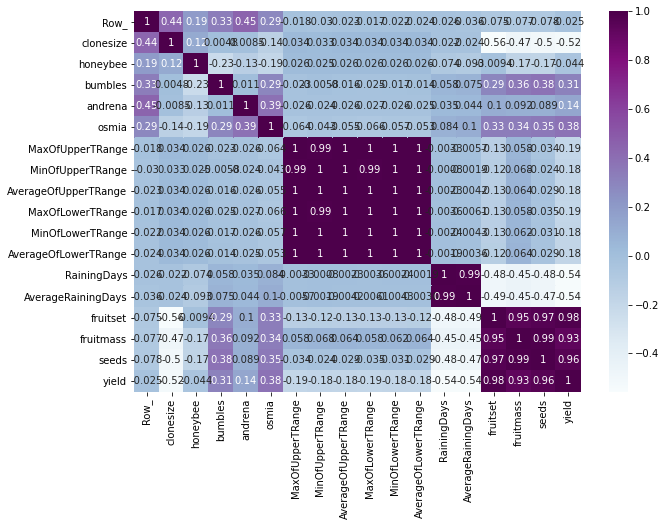

In [27]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
# import file with data
#data = regression_data
pd.read_csv("./WildBlueberryPollinationSimulationData.csv")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
print(data.corr())

# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="BuPu", annot=True)

# displaying heatmap
mp.show()

## <b>Correlation Notes:</b>
The environmental variables such as temperature of upper and lower air ranges, and rainy days have the most correlation to yield, fruitset, fruitmass and seeds.
As there is not much we can do to affect the natural weather conditions, we should look to the variables we can have an effect on, namely the pollinator's themselves.

Among the pollinators we can see that the Osmia and Bumbles are most correlated to fruitmass, seeds and yield, despite having p-values of <0.01.

# OLS Regressions

## Model I

In [28]:
import statsmodels.api as sm

dependent_vars = regression_data['yield']
independent_vars = regression_data[['clonesize','fruitmass','RainingDays', 'honeybee', 'bumbles', 'andrena', 'osmia']]
independent_vars['constant'] = np.ones((independent_vars.shape[0],)) #add a constant column for the regression

#make sure all our data is numeric
dependent_vars = dependent_vars.apply(float)
independent_vars = independent_vars.applymap(float)

#create our linear regression class, with our data
lin_reg = sm.OLS(dependent_vars, independent_vars)
reg_results = lin_reg.fit() #fit the model to the data using the fit method
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1565.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:26:26   Log-Likelihood:                -5648.1
No. Observations:                 777   AIC:                         1.131e+04
Df Residuals:                     769   BIC:                         1.135e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
clonesize     -39.5523      2.265    -17.465      

## Model II
dropping clonesize, and we get some interesting P values which confirm earlier observation that bumbles have some elevated significance in the yield output of blueberries

In [29]:
indep2 = independent_vars[['fruitmass','RainingDays', 'honeybee', 'bumbles', 'andrena', 'osmia', 'constant']]

lin_reg2 = sm.OLS(dependent_vars, indep2)
regression2 = lin_reg2.fit()

print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1273.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:26:31   Log-Likelihood:                -5777.9
No. Observations:                 777   AIC:                         1.157e+04
Df Residuals:                     770   BIC:                         1.160e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
fruitmass    2.762e+04    488.367     56.546      

In [30]:
import seaborn as sns
sns.set_theme(color_codes=True)

# Figures

<h3>Figure 1. Correlation Heat Map of Regression Variables</h3>

                yield  RainingDays  clonesize  fruitmass  honeybee   bumbles  \
yield        1.000000    -0.540069  -0.516737   0.930365 -0.044250  0.309407   
RainingDays -0.540069     1.000000  -0.021696  -0.452328 -0.073818  0.058063   
clonesize   -0.516737    -0.021696   1.000000  -0.474038  0.119745  0.004807   
fruitmass    0.930365    -0.452328  -0.474038   1.000000 -0.166419  0.358202   
honeybee    -0.044250    -0.073818   0.119745  -0.166419  1.000000 -0.233954   
bumbles      0.309407     0.058063   0.004807   0.358202 -0.233954  1.000000   
andrena      0.140277     0.035297  -0.008451   0.092470 -0.125913  0.010758   
osmia        0.380892     0.083667  -0.139049   0.336136 -0.189058  0.293665   

              andrena     osmia  
yield        0.140277  0.380892  
RainingDays  0.035297  0.083667  
clonesize   -0.008451 -0.139049  
fruitmass    0.092470  0.336136  
honeybee    -0.125913 -0.189058  
bumbles      0.010758  0.293665  
andrena      1.000000  0.387379  
osmia  

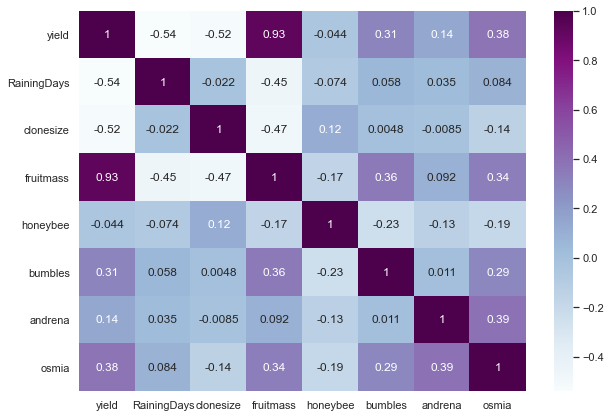

In [31]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
# import file with data
data = regression_data
#pd.read_csv("./WildBlueberryPollinationSimulationData.csv")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
print(data.corr())

# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="BuPu", annot=True)

# displaying heatmap
mp.show()

<h3><b>Observations I</b></h3>

I removed the temerature data and created a second heatmap whcih agrees with the first map that <b>fruitmass</b> has the highest correlation to yield.  It also suggests Bumbles and Osmia bees have a decent correlation to yield. <b>Osmia has the highest correlation to yield output than all the other pollinators.</b>

<h3>Figure 2. Pair Plot Regression Data</h3>

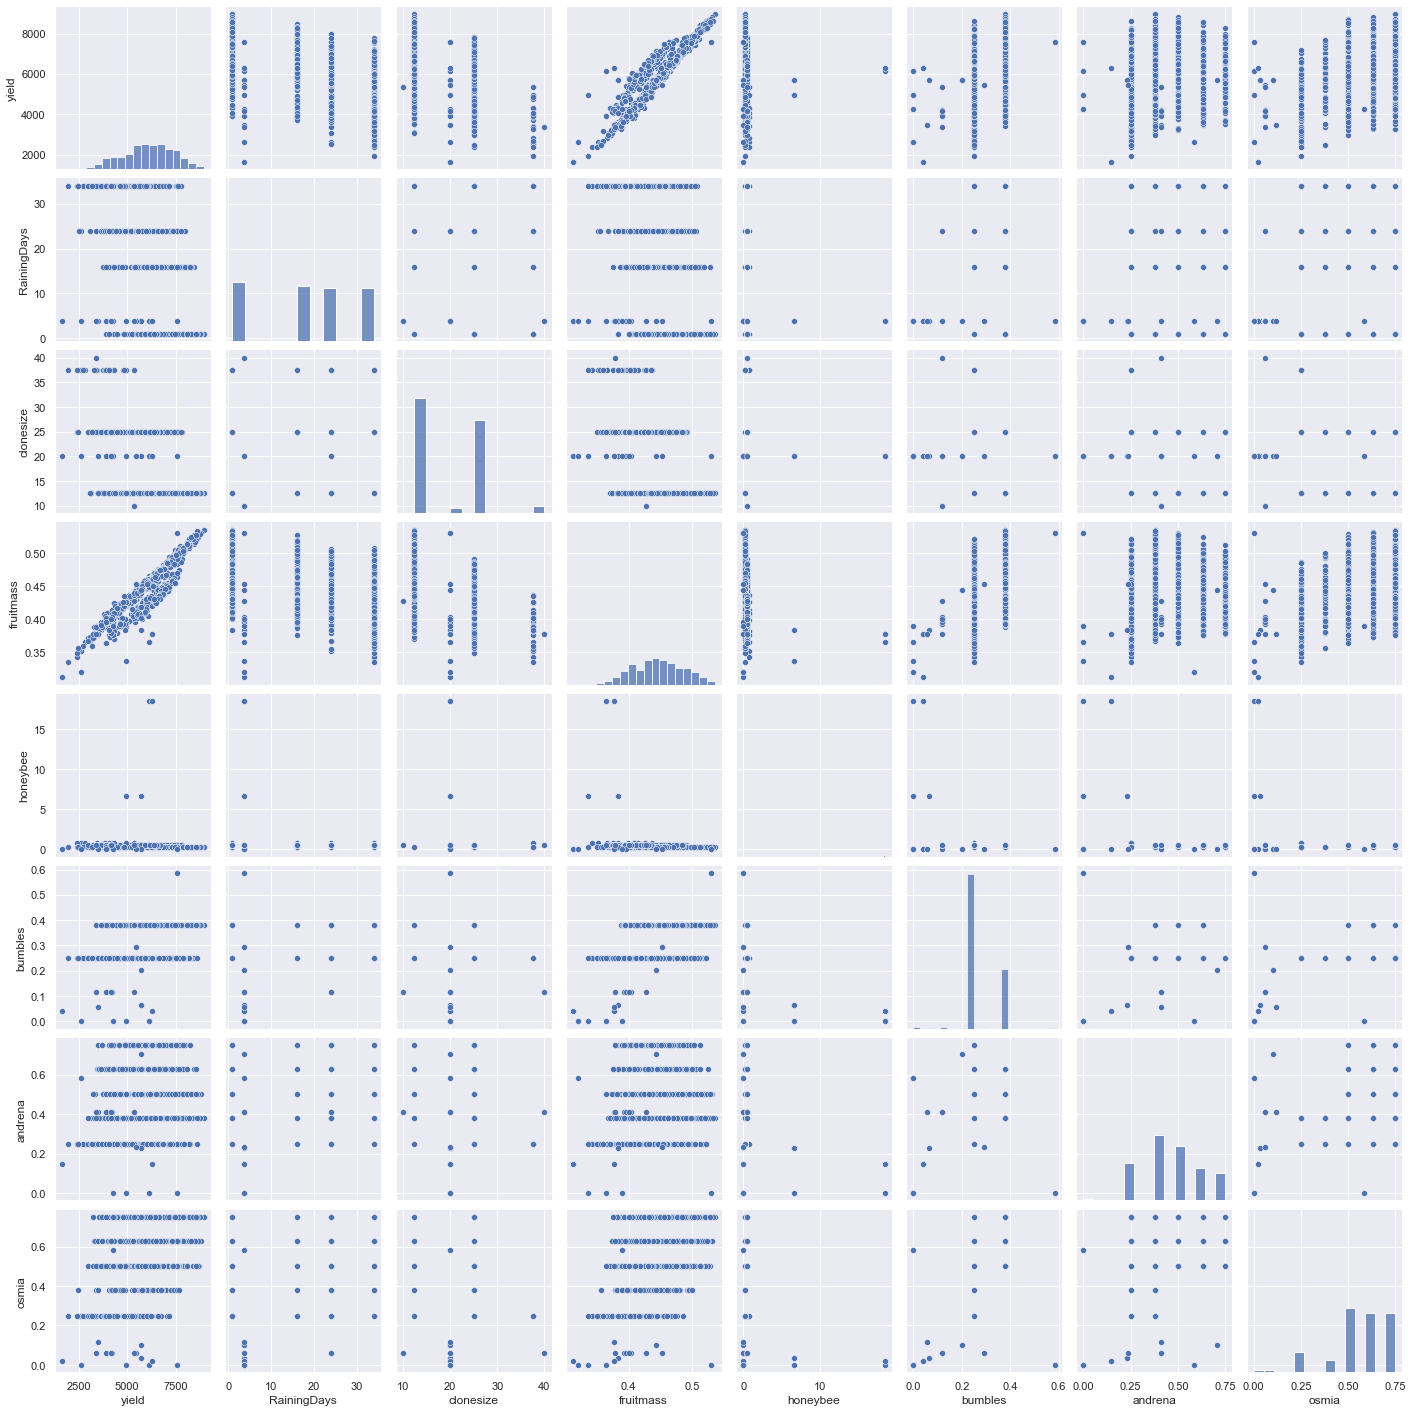

In [32]:
sns.pairplot(regression_data)

<h3><b>Observations II</b></h3>

1. Correlation: The shapes of the yield and fruitmass histograms are very similar, confirming their high correlation.
2. Bee Density: Andrena bees have the most uniform distribution per square meter ranging between 0.20 and 0.75 bees per square meter. Osmia are less evenly but more densely packed between the 0.50 to 0.75 bee per square meter, Bumbles fall between 0.25 and 0.40 per square meter, and honeybees are scarce.
3. In all but one pollinator group (the honeybee, which rarely rises above 0.20 per square meter) fruitmass stabilizes when bee density rises above 0.20 per square meter.

<p><h3><b>Question</b></h3></p>
<p>Looking at the densities of each pollinator, I notice that honeybees are scarce in this sample and Osmia are quite dense which makes me wonder how the results would differ if all pollinator groups had the same value per meter squared?</p>
<p>This question brings me to change my Hypothesis from, "The pollinator species IS significant to the ultimate total yield of blueberries", to "Bees per meter squared are <b>more significant</b> to yield than the bee species"</p>

<b>Below I will compare scatter plots of bee density by paired groups, with bee density by yield output.<b>

# Comparing Bees to Bees
to see how density varies between pollinator species across the territories they share.

<h3>Figure 3. Scatter Plot Bumbles & Honeybee</h3>
we can see how scarce Honeybees are

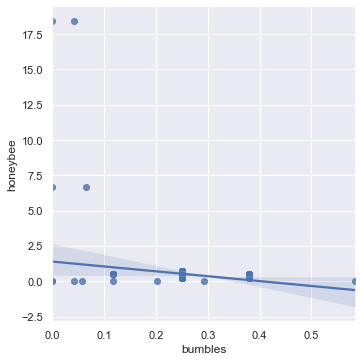

In [33]:
sns.lmplot(x="bumbles", y="honeybee", data=df);

<h3>Figure 4. Scatter Plot Bumbles & Osmia</h3>
Osmia and Bumbles are more evenly distributed, but Osmia are more plentiful.

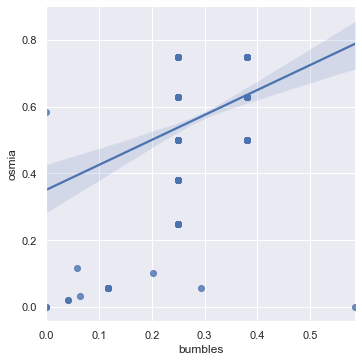

In [34]:
sns.lmplot(x="bumbles", y="osmia", data=df);

<h3>Figure 5. Scatter Plot Bumbles & Andrena</h3>
Fairly evenly matched

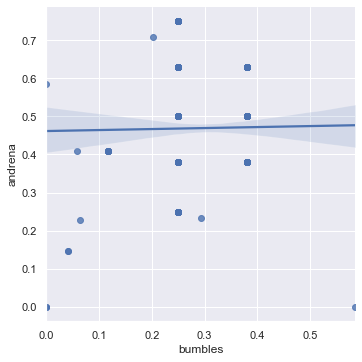

In [35]:
sns.lmplot(x="bumbles", y="andrena", data=df);

<h3>Figure 6. Scatter Plot Osmia & Andrena</h3>
Similar match to Osmia and Bumbles.  Osmia slightly more plentiful.

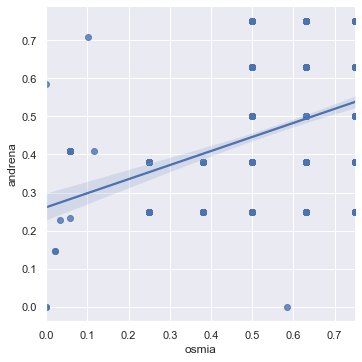

In [36]:
sns.lmplot(x="osmia", y="andrena", data=df);

<h3>Figure 7. Scatter Plot Honeybee & Osmia</h3>
we can see honeybees hover on the zero line, where Osmia is packed around 0.5 bees per square meter

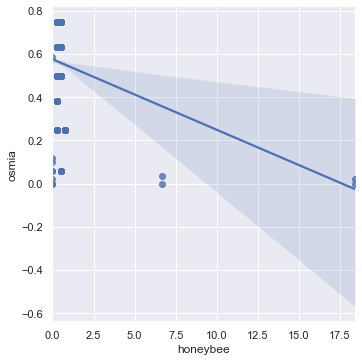

In [37]:
sns.lmplot(x="honeybee", y="osmia", data=df);

<h3>Figure 8. Scatter Plot Honeybee & Andrena</h3>
Honeybees fair better where Andrena bees are found rising from 0 to 0.20 per squared meter

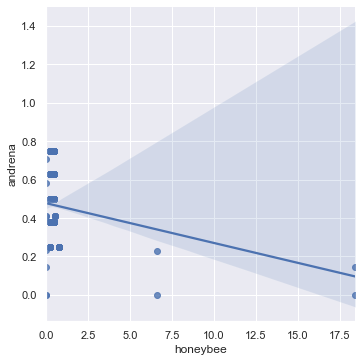

In [38]:
sns.lmplot(x="honeybee", y="andrena", data=df);

# Comparing Bee Species to Yield

<h3>Figure 9. Scatter Plot Bumbles & Yield</h3>
Bumbles low end yield starts above 2,000 units

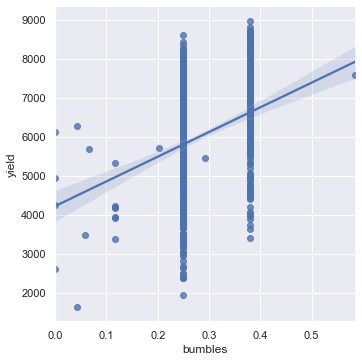

In [39]:
sns.lmplot(x="bumbles", y="yield", data=df);


<h3>Figure 10. Scatter Plot Honeybee & Yield</h3>
We can see that honeybee produces the least yield from just above 0 to the 5,000 unit mark.

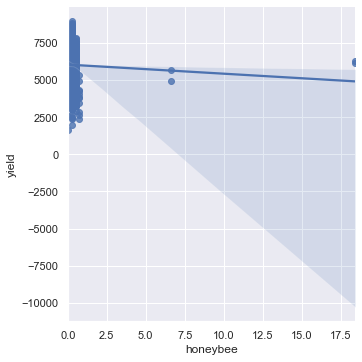

In [40]:
sns.lmplot(x="honeybee", y="yield", data=df);

<h3>Figure 12. Scatter Plot Osmia & Yield</h3>
Whereas Osmia's lower end of yield hovers above 2,000 is packed between 4,000 and 6,000 and reached 9,000 at the high end.

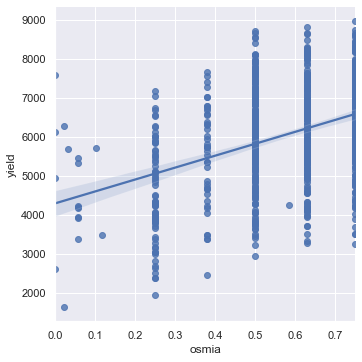

In [41]:
sns.lmplot(x="osmia", y="yield", data=df);

<h3>Figure 11. Scatter Plot Andrena & Yield</h3>

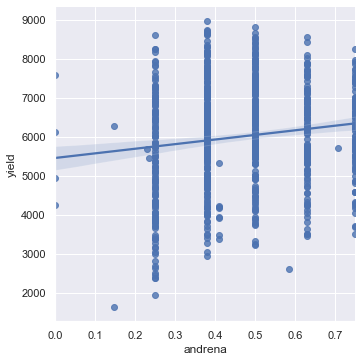

In [42]:
sns.lmplot(x="andrena", y="yield", data=df);

<h3><b>Lets look at the relationships between Pollinator group and yield, by clonesize and fruitmass</b></h3>

<h3>Figure 13. Relational Plot Bumbles & Yield, by clonesize & fruitmass</h3>

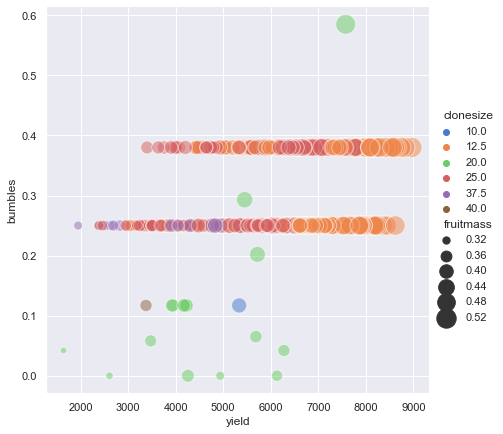

In [43]:
sns.relplot(x="yield", y="bumbles", hue="clonesize", size="fruitmass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

<h3>Figure 14. Relational Plot Osmia & Yield, by clonesize & fruitmass</h3>

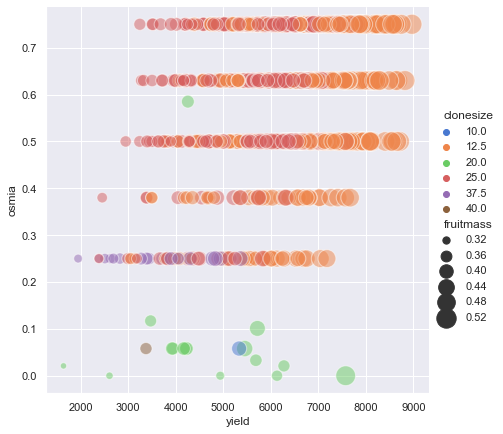

In [44]:
sns.relplot(x="yield", y="osmia", hue="clonesize", size="fruitmass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

<h3> Figure 15. Relational Plot Andrena & Yield, by clonesize & fruitmass</h3>

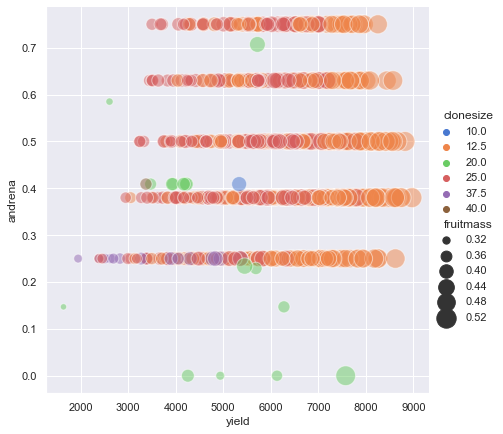

In [45]:
sns.relplot(x="yield", y="andrena", hue="clonesize", size="fruitmass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

<h3>Figure 13. Relational Plot Honeybee & Yield, by clonesize & fruitmass</h3>

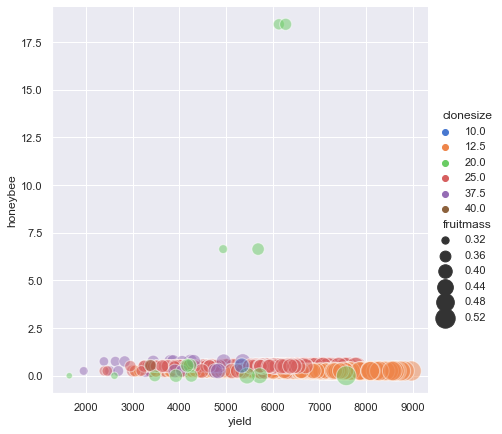

In [46]:
sns.relplot(x="yield", y="honeybee", hue="clonesize", size="fruitmass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

<h3><b>Observations III</b></h3>
Bee Density including mixture of species, has more impact on yield than a single pollinator species on its own.

# <b>Predicting Bee Density</b>
I chose to use a random forest regression model because it employs ensemble learning: the combining of more than one model, in this case multiple 'decision trees'.  Increasing the number of decision trees, increases the model accuracy and eases the issue of over fitting.

## Preprocessing

In [47]:
#importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV #optimixing hyperparameters of the model
from sklearn.preprocessing import StandardScaler #for pre-processing

from sklearn.ensemble import RandomForestRegressor #

#import data
from sklearn.datasets import make_blobs

# scikitplot to directly plot our results
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

# matplotlib for plotting modification
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
X_train, X_test, y_train, y_test = preprocess_inputs(data) #defining training model
X_train #lets look at the X_train to see honeybee has been dropped

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
214,12.5,0.25,0.250,0.50,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.00,0.10,0.582954,0.488176,40.559770
88,12.5,0.25,0.250,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.435969,0.419720,32.815794
479,25.0,0.50,0.250,0.38,0.63,94.6,57.2,79.0,68.2,33.0,55.9,24.00,0.39,0.364565,0.391617,29.908518
602,25.0,0.50,0.250,0.75,0.50,86.0,52.0,71.9,62.0,30.0,50.8,1.00,0.10,0.523846,0.460305,37.277297
147,12.5,0.25,0.250,0.38,0.38,86.0,52.0,71.9,62.0,30.0,50.8,16.00,0.26,0.553730,0.471250,38.534569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,25.0,0.50,0.380,0.50,0.63,94.6,57.2,79.0,68.2,33.0,55.9,16.00,0.26,0.527592,0.464639,37.782288
767,20.0,0.00,0.585,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.599984,0.529791,46.585105
72,12.5,0.25,0.250,0.25,0.38,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.416271,0.409438,31.577558
235,12.5,0.25,0.250,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,16.00,0.26,0.589306,0.488616,40.546480


In [72]:
y_train #lets check y_train

214    7243.226111
88     4684.893205
479    3723.523376
602    6521.291119
147    6683.200614
          ...     
715    6327.477365
767    7575.801245
72     4350.424670
235    7560.205645
37     4356.945873
Name: yield, Length: 543, dtype: float64

## Training for Honeybees

In [73]:
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) #now we can predict for y which in this data set is for honeybees
y_pred #lets look at the predictions

array([8347.89770723, 5617.43353994, 6040.91770472, 4173.93171129,
       8473.76616715, 7234.76702628, 6225.91778631, 6859.34549124,
       6637.02444783, 6580.87958142, 5669.79024112, 5777.39852827,
       4465.31845819, 7805.50049886, 6675.22715612, 5921.94715828,
       4530.86721559, 7435.78687431, 7823.00351099, 5233.51084744,
       6296.30291283, 3738.70103395, 7624.08015921, 5626.33850482,
       5209.72012965, 5977.9733837 , 3630.90959874, 4334.47925919,
       5753.88279328, 4614.79823169, 6710.7406748 , 3790.68113273,
       5144.07202304, 8407.99085595, 7423.64841492, 6837.64713186,
       6755.38550009, 5670.1757635 , 5379.44014731, 8732.92815879,
       8170.96906526, 6758.20597224, 2611.7916052 , 5807.17117923,
       7103.17276231, 5410.07050787, 4690.53921909, 5777.89016355,
       4335.91768002, 5830.45196381, 5043.65935806, 7566.67442886,
       7822.88966909, 7255.44162752, 3539.58488246, 6306.49081446,
       4780.87702349, 5272.44565973, 5129.63675496, 6462.19274

In [74]:
#to find the error rate we take the y_test and subtract y_pred, find the mean and square root that
np.sqrt(np.mean((y_test - y_pred)**2))

186.22786817455614

In [75]:
#finding the r squared score for the baseline model
y_test #baseline model)

374    8211.079500
491    5632.459174
678    5966.711278
720    4201.435956
412    8538.462001
          ...     
245    7483.736315
435    8318.798885
657    6503.272041
560    3447.082101
11     3941.255122
Name: yield, Length: 234, dtype: float64

In [76]:
#calculating the mean error for each row of the baseline model
y_test - y_test.mean()

374    2247.608810
491    -331.011516
678       3.240588
720   -1762.034734
412    2574.991311
          ...     
245    1520.265625
435    2355.328195
657     539.801351
560   -2516.388589
11    -2022.215568
Name: yield, Length: 234, dtype: float64

In [77]:
#now we're squaring the errors to get them on the positive scale (normalizing) and finding the sum of said errors
np.sum((y_test -y_test.mean())**2)

462021092.3782098

In [78]:
#now we're looking for the sum of errors on our preditive model
np.sum((y_test -y_pred)**2)

8115311.619052531

In [79]:
#checking the percent of reduction in the error by dividing the pred errors by mean errors
np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.017564807652567835

In [80]:
#getting our r squared score.  1 - 0 = 1
1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.9824351923474322

In [81]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = 1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)
print ('     RMSE: {:.2f}'.format(rmse))
print("R^2 Score: {:.5f}".format(r2))

     RMSE: 186.23
R^2 Score: 0.98244


## Honeybee RMSE and R^2 Score
RMSE: 0.84
R^2 Score: 0.59584

## Preprocessing for Bumbles

In [83]:
def preprocess_inputs (df): # defining a function that will make a copy of the dataframe
    df = df.copy()
    
    #drop unnecessary row column
    df = df.drop('Row#', axis = 1)
    
    # split df along dependent and independent (or target) variables. I am predicting yield, so that is the target variable to isolate from the rest of the variables for testing.
    y = df['bumbles'] #putting test variable onto y axis
    X = df.drop('bumbles', axis=1) #dropping test variable from X axis

    
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    return   X_train, X_test, y_train, y_test

In [84]:
X_train, X_test, y_train, y_test = preprocess_inputs(data) #defining training model

In [85]:
X_train #lets look at the X_train to see bumbles has been dropped

,clonesize,honeybee,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
214,12.5,0.25,0.50,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.00,0.10,0.582954,0.488176,40.559770,7243.226111
88,12.5,0.25,0.25,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.435969,0.419720,32.815794,4684.893205
479,25.0,0.50,0.38,0.63,94.6,57.2,79.0,68.2,33.0,55.9,24.00,0.39,0.364565,0.391617,29.908518,3723.523376
602,25.0,0.50,0.75,0.50,86.0,52.0,71.9,62.0,30.0,50.8,1.00,0.10,0.523846,0.460305,37.277297,6521.291119
147,12.5,0.25,0.38,0.38,86.0,52.0,71.9,62.0,30.0,50.8,16.00,0.26,0.553730,0.471250,38.534569,6683.200614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,25.0,0.50,0.50,0.63,94.6,57.2,79.0,68.2,33.0,55.9,16.00,0.26,0.527592,0.464639,37.782288,6327.477365
767,20.0,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.599984,0.529791,46.585105,7575.801245
72,12.5,0.25,0.25,0.38,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.416271,0.409438,31.577558,4350.424670
235,12.5,0.25,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,16.00,0.26,0.589306,0.488616,40.546480,7560.205645


In [86]:
y_train #lets check y_train

214    0.250
88     0.250
479    0.250
602    0.250
147    0.250
       ...  
715    0.380
767    0.585
72     0.250
235    0.250
37     0.250
Name: bumbles, Length: 543, dtype: float64

## Training for Bumbles

In [87]:
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) #now we can predict for y which in this data set is bumbles

In [88]:
y_pred #lets look at the predictions

array([0.3579 , 0.2682 , 0.3631 , 0.3254 , 0.3735 , 0.2552 , 0.2565 ,
       0.2851 , 0.2552 , 0.2708 , 0.2552 , 0.2617 , 0.3189 , 0.328  ,
       0.2513 , 0.3475 , 0.2526 , 0.3501 , 0.3683 , 0.2526 , 0.2669 ,
       0.2721 , 0.25   , 0.2903 , 0.2929 , 0.2786 , 0.276  , 0.12755,
       0.2903 , 0.2864 , 0.25   , 0.2539 , 0.2552 , 0.3527 , 0.2539 ,
       0.25   , 0.25   , 0.2643 , 0.2604 , 0.3722 , 0.3709 , 0.367  ,
       0.25   , 0.2604 , 0.367  , 0.263  , 0.2604 , 0.2604 , 0.2994 ,
       0.3631 , 0.2877 , 0.25985, 0.3202 , 0.3618 , 0.2604 , 0.3072 ,
       0.3163 , 0.2903 , 0.25   , 0.2539 , 0.2513 , 0.2838 , 0.25   ,
       0.3644 , 0.25   , 0.25   , 0.2513 , 0.2695 , 0.2695 , 0.3696 ,
       0.2513 , 0.25   , 0.25   , 0.302  , 0.3774 , 0.2773 , 0.2513 ,
       0.2513 , 0.25563, 0.2682 , 0.3722 , 0.2526 , 0.2773 , 0.2578 ,
       0.2643 , 0.25   , 0.2721 , 0.2526 , 0.25173, 0.12654, 0.3657 ,
       0.2513 , 0.2565 , 0.25823, 0.2877 , 0.2617 , 0.3371 , 0.3423 ,
       0.11977, 0.35

In [89]:
#to find the error rate we take the y_test and subtract y_pred, find the mean and square root that
np.sqrt(np.mean((y_test - y_pred)**2))

0.039339995269163146

In [90]:
#finding the r squared score for the baseline model
y_test #baseline model)

374    0.38
491    0.25
678    0.38
720    0.38
412    0.38
       ... 
245    0.25
435    0.38
657    0.38
560    0.25
11     0.25
Name: bumbles, Length: 234, dtype: float64

In [91]:
#calculating the mean error for each row of the baseline model
y_test - y_test.mean()

374    0.099299
491   -0.030701
678    0.099299
720    0.099299
412    0.099299
         ...   
245   -0.030701
435    0.099299
657    0.099299
560   -0.030701
11    -0.030701
Name: bumbles, Length: 234, dtype: float64

In [92]:
#now we're squaring the errors to get them on the positive scale (normalizing) and finding the sum of said errors
np.sum((y_test -y_test.mean())**2)

1.22340105982906

In [93]:
#now we're looking for the sum of errors on our preditive model
np.sum((y_test -y_pred)**2)

0.36214664330000024

In [94]:
#checking the percent of reduction in the error by dividing the pred errors by mean errors
np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.2960162903166042

In [95]:
#getting our r squared score.  1 - 0 = 1
1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.7039837096833959

In [96]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = 1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)
print ('     RMSE: {:.2f}'.format(rmse))
print("R^2 Score: {:.5f}".format(r2))

     RMSE: 0.04
R^2 Score: 0.70398


## Bumble Bee RMSE and R^2 Score
RMSE: 0.04
R^2 Score: 0.70398

##  Preprocessing for Adrena Bees

In [97]:
def preprocess_inputs (df): # defining a function that will make a copy of the dataframe
    df = df.copy()
    
    #drop unnecessary row column
    df = df.drop('Row#', axis = 1)
    
    # split df along dependent and independent (or target) variables. I am predicting yield, so that is the target variable to isolate from the rest of the variables for testing.
    y = df['andrena'] #putting test variable onto y axis
    X = df.drop('andrena', axis=1) #dropping test variable from X axis

    
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    return   X_train, X_test, y_train, y_test

In [98]:
X_train, X_test, y_train, y_test = preprocess_inputs(data) #defining training model
X_train #lets look at the X_train to see yield has been dropped

,clonesize,honeybee,bumbles,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
214,12.5,0.25,0.250,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.00,0.10,0.582954,0.488176,40.559770,7243.226111
88,12.5,0.25,0.250,0.50,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.435969,0.419720,32.815794,4684.893205
479,25.0,0.50,0.250,0.63,94.6,57.2,79.0,68.2,33.0,55.9,24.00,0.39,0.364565,0.391617,29.908518,3723.523376
602,25.0,0.50,0.250,0.50,86.0,52.0,71.9,62.0,30.0,50.8,1.00,0.10,0.523846,0.460305,37.277297,6521.291119
147,12.5,0.25,0.250,0.38,86.0,52.0,71.9,62.0,30.0,50.8,16.00,0.26,0.553730,0.471250,38.534569,6683.200614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,25.0,0.50,0.380,0.63,94.6,57.2,79.0,68.2,33.0,55.9,16.00,0.26,0.527592,0.464639,37.782288,6327.477365
767,20.0,0.00,0.585,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.599984,0.529791,46.585105,7575.801245
72,12.5,0.25,0.250,0.38,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.416271,0.409438,31.577558,4350.424670
235,12.5,0.25,0.250,0.63,77.4,46.8,64.7,55.8,27.0,45.8,16.00,0.26,0.589306,0.488616,40.546480,7560.205645


In [99]:
y_train #lets check y_train

214    0.50
88     0.25
479    0.38
602    0.75
147    0.38
       ... 
715    0.50
767    0.00
72     0.25
235    0.50
37     0.25
Name: andrena, Length: 543, dtype: float64

## Training for Adrena Bees¶


In [100]:
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) #now we can predict for y which in this data set is yield

In [101]:
y_pred #lets look at the predictions

array([0.4711 , 0.5554 , 0.4135 , 0.4193 , 0.4985 , 0.529  , 0.5401 ,
       0.6197 , 0.5761 , 0.4815 , 0.5546 , 0.5229 , 0.4576 , 0.5161 ,
       0.3156 , 0.4618 , 0.25   , 0.5015 , 0.4485 , 0.5661 , 0.6476 ,
       0.4071 , 0.5067 , 0.5333 , 0.6117 , 0.5399 , 0.5596 , 0.38106,
       0.609  , 0.522  , 0.4731 , 0.4651 , 0.2721 , 0.4399 , 0.5844 ,
       0.6062 , 0.5703 , 0.5557 , 0.5899 , 0.3993 , 0.5507 , 0.4173 ,
       0.25   , 0.5583 , 0.4667 , 0.4681 , 0.25   , 0.34557, 0.6025 ,
       0.445  , 0.5102 , 0.3658 , 0.5177 , 0.4319 , 0.6305 , 0.4664 ,
       0.4796 , 0.4681 , 0.5619 , 0.3059 , 0.5801 , 0.5458 , 0.3592 ,
       0.4733 , 0.4795 , 0.25   , 0.546  , 0.5581 , 0.4809 , 0.4201 ,
       0.5536 , 0.36267, 0.6249 , 0.4736 , 0.468  , 0.4714 , 0.25   ,
       0.6289 , 0.33564, 0.5733 , 0.4744 , 0.5058 , 0.4965 , 0.5717 ,
       0.34389, 0.5185 , 0.418  , 0.5668 , 0.6564 , 0.32648, 0.4196 ,
       0.6154 , 0.2526 , 0.5306 , 0.5329 , 0.427  , 0.4484 , 0.4518 ,
       0.3676 , 0.41

In [102]:
#to find the error rate we take the y_test and subtract y_pred, find the mean and square root that
np.sqrt(np.mean((y_test - y_pred)**2))

0.14335602935546207

In [103]:
#finding the r squared score for the baseline model
y_test #baseline model)

374    0.38
491    0.38
678    0.38
720    0.50
412    0.50
       ... 
245    0.50
435    0.50
657    0.38
560    0.63
11     0.25
Name: andrena, Length: 234, dtype: float64

In [104]:
#calculating the mean error for each row of the baseline model
y_test - y_test.mean()

374   -0.071774
491   -0.071774
678   -0.071774
720    0.048226
412    0.048226
         ...   
245    0.048226
435    0.048226
657   -0.071774
560    0.178226
11    -0.201774
Name: andrena, Length: 234, dtype: float64

In [105]:
#now we're squaring the errors to get them on the positive scale (normalizing) and finding the sum of said errors
np.sum((y_test -y_test.mean())**2)

6.072828995726496

In [106]:
#now we're looking for the sum of errors on our preditive model
np.sum((y_test -y_pred)**2)

4.8089225697000035

In [107]:
#checking the percent of reduction in the error by dividing the pred errors by mean errors
np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.7918751825687971

In [108]:
#getting our r squared score.  1 - 0 = 1
1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.20812481743120292

In [109]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = 1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)
print ('     RMSE: {:.2f}'.format(rmse))
print("R^2 Score: {:.5f}".format(r2))

     RMSE: 0.14
R^2 Score: 0.20812


## Adrena Bees RMSE and R^2 Score
RMSE: 0.14
R^2 Score: 0.20812

## Preprocessing for Osmia Bees

In [110]:
def preprocess_inputs (df): # defining a function that will make a copy of the dataframe
    df = df.copy()
    
    #drop unnecessary row column
    df = df.drop('Row#', axis = 1)
    
    # split df along dependent and independent (or target) variables. I am predicting yield, so that is the target variable to isolate from the rest of the variables for testing.
    y = df['osmia'] #putting test variable onto y axis
    X = df.drop('osmia', axis=1) #dropping test variable from X axis

    
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    return   X_train, X_test, y_train, y_test

In [111]:
X_train, X_test, y_train, y_test = preprocess_inputs(data) #defining training model
X_train #lets look at the X_train to see yield has been dropped

,clonesize,honeybee,bumbles,andrena,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
214,12.5,0.25,0.250,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.00,0.10,0.582954,0.488176,40.559770,7243.226111
88,12.5,0.25,0.250,0.25,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.435969,0.419720,32.815794,4684.893205
479,25.0,0.50,0.250,0.38,94.6,57.2,79.0,68.2,33.0,55.9,24.00,0.39,0.364565,0.391617,29.908518,3723.523376
602,25.0,0.50,0.250,0.75,86.0,52.0,71.9,62.0,30.0,50.8,1.00,0.10,0.523846,0.460305,37.277297,6521.291119
147,12.5,0.25,0.250,0.38,86.0,52.0,71.9,62.0,30.0,50.8,16.00,0.26,0.553730,0.471250,38.534569,6683.200614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,25.0,0.50,0.380,0.50,94.6,57.2,79.0,68.2,33.0,55.9,16.00,0.26,0.527592,0.464639,37.782288,6327.477365
767,20.0,0.00,0.585,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.599984,0.529791,46.585105,7575.801245
72,12.5,0.25,0.250,0.25,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.416271,0.409438,31.577558,4350.424670
235,12.5,0.25,0.250,0.50,77.4,46.8,64.7,55.8,27.0,45.8,16.00,0.26,0.589306,0.488616,40.546480,7560.205645


In [112]:
y_train #lets check y_train

214    0.50
88     0.50
479    0.63
602    0.50
147    0.38
       ... 
715    0.63
767    0.00
72     0.38
235    0.63
37     0.25
Name: osmia, Length: 543, dtype: float64

## Training for Osmia Bees

In [114]:
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) #now we can predict for y which in this data set is Osmia

In [115]:
y_pred #lets look at the predictions

array([0.6469 , 0.6039 , 0.6903 , 0.6152 , 0.68   , 0.6471 , 0.5762 ,
       0.6665 , 0.6233 , 0.6071 , 0.6407 , 0.6013 , 0.5158 , 0.6352 ,
       0.5891 , 0.5939 , 0.2513 , 0.6302 , 0.6572 , 0.5987 , 0.5918 ,
       0.5465 , 0.6606 , 0.6584 , 0.5875 , 0.6415 , 0.5806 , 0.09116,
       0.5839 , 0.5592 , 0.5891 , 0.5312 , 0.5166 , 0.6383 , 0.6546 ,
       0.6355 , 0.5937 , 0.6889 , 0.6301 , 0.6193 , 0.6196 , 0.6464 ,
       0.2539 , 0.5985 , 0.6684 , 0.6303 , 0.2642 , 0.5207 , 0.6847 ,
       0.6199 , 0.5461 , 0.6165 , 0.629  , 0.7022 , 0.5883 , 0.6025 ,
       0.537  , 0.609  , 0.6055 , 0.4239 , 0.6025 , 0.6679 , 0.6042 ,
       0.6356 , 0.4919 , 0.25   , 0.5962 , 0.6179 , 0.5825 , 0.633  ,
       0.5107 , 0.4736 , 0.6609 , 0.5976 , 0.7074 , 0.5535 , 0.2591 ,
       0.5721 , 0.3406 , 0.586  , 0.5513 , 0.4451 , 0.6395 , 0.5844 ,
       0.36358, 0.3378 , 0.6192 , 0.527  , 0.6058 , 0.06842, 0.6037 ,
       0.5871 , 0.2734 , 0.6127 , 0.5936 , 0.603  , 0.6313 , 0.6648 ,
       0.08347, 0.64

In [116]:
#to find the error rate we take the y_test and subtract y_pred, find the mean and square root that
np.sqrt(np.mean((y_test - y_pred)**2))

0.13161300787165991

In [117]:
#finding the r squared score for the baseline model
y_test #baseline model)

374    0.63
491    0.75
678    0.63
720    0.63
412    0.50
       ... 
245    0.75
435    0.75
657    0.50
560    0.50
11     0.25
Name: osmia, Length: 234, dtype: float64

In [118]:
#calculating the mean error for each row of the baseline model
y_test - y_test.mean()

374    0.063124
491    0.183124
678    0.063124
720    0.063124
412   -0.066876
         ...   
245    0.183124
435    0.183124
657   -0.066876
560   -0.066876
11    -0.316876
Name: osmia, Length: 234, dtype: float64

In [119]:
#now we're squaring the errors to get them on the positive scale (normalizing) and finding the sum of said errors
np.sum((y_test -y_test.mean())**2)

7.792751405982906

In [120]:
#now we're looking for the sum of errors on our preditive model
np.sum((y_test -y_pred)**2)

4.053344218799998

In [121]:
#checking the percent of reduction in the error by dividing the pred errors by mean errors
np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.5201428876183618

In [122]:
#getting our r squared score.  1 - 0 = 1
1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)

0.4798571123816382

In [123]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = 1 - np.sum((y_test -y_pred)**2)/np.sum((y_test -y_test.mean())**2)
print ('     RMSE: {:.2f}'.format(rmse))
print("R^2 Score: {:.5f}".format(r2))

     RMSE: 0.13
R^2 Score: 0.47986


## Osmia RMSE and R^2 Score
RMSE: 0.13
R^2 Score: 0.47986

## Observations IV

### On forrest generated regression models to test pollinator densities against yield 

<p><b>Honeybee RMSE: 0.84 with a R^2 value of 0.59584</b>
Not a particularily accurate model, not showing much correlation to yield</p>
    
<p><b>Bumbles RMSE: 0.04 with an R^2 value of 0.70398 </b>
    Well fit model, decent R^2 value, decent correlation to yield</p>

<p><b>Osmia RMSE: 0.13 with an R^2 value of 0.47986 </b>
    weak correlation to yield</p></b>
    
<b>Andrena RMSE: 0.14 with an R^2 value of 0.20812</b>
    weak correaltion to yield
    

# Conclusion

What have we learned?

<p>The variables in this data set that most strongly correlate to blueberry yields are Air Temperatures, Rainy Days, and fruitmass.  
    
    Of the variables we can have an effect on is bee density. Yields begin to rise at a minimum of 0.20 bees per square meter.  This observation holds true regardless of the pollinator species, however one species appears to have a lessor impact on blueberry yield than the others.  The honeybee</p>

<p> When we look at <b>the correlation heat map for all variables,</b> we see Osmia, Andrena and Bumbles correlate most strongly to yield, fruitmass and seed. When we look at the <b>Forrest Regression Models</b> Bumbles is the only pollinator we can confidently correlate with yield.  When we look at <b>relational plots</b> we see Osmia and Andrena outperform in yield and fruitmass over all others.</p>
<p>Osmia has the highest mean density at 0.56 bees per square meter with Andrena in second with a mean density of 0.46 bees per square meter. </p>

If these results vary on the importance of bumble andrena and osmia bees to yield, they all agree on the lack of impact made by the honeybee.  

What can we make of this?  Outside of sunshine and precipitation, the most important thing to affect blueberry production is the density of the bees whose territory extends to the Blueberry fields of this study.  Looking at each bee species independently gives us a bunch of wishy washy results.  However, when we compare Bees to Bees we can see pollinators with similar high densities consistently score higher on correlation to yield.  The correlation heat map illustrates this relationship as does the OLS regression. 



# Recommendations

 <p>Osmia are wild bees, native to North America where this data was collected. They are also known as the 'Mason" bee because of the manner in which they construct their nests.  They use mud and create a sort of brick and morter to seal naturally occuring cracks in stones and other natural cavities. Andrena are a native species, and are known as the "Miner" bee's because they dig holes to make their nests.  Honeybees are not wild, they are domesticated and most often live in structures created by human hands.  These colonies can get quite large and last for decades while our wild species tend to live in small groups or even as solitary beings.  Honeybees are best used in blueberry cultivation to 'prop up' the other active, wild species of the territory, a tactic captured in this analysis.</p>
 
 1. support local wild bee populations by augmenting the territories with native plants that work well with blueberries and the soil blueberries grow in.  Of specific interest are of course, blooming plants, flowers and shrubs.
 2. Support the 'Mason' and 'Miner' bees by cultivating diverse forest and field floors. For example, scattering field stones and leaving fallen tree branches in the bee territories will provide suitable material for the construction of their nests.
 3. Ensuring access to water, for bee refreshment and for the Mason's mortar needs.
 4. Engage community support by encouraging pollinator friendly local landscaping and gardens to help ensure the bees get maximum nutrients during blooming season.